In [134]:
%matplotlib inline

In [410]:
import inspect
import hashlib
import re
import networkx as nx
import os

class Task:
    def __init__(self, name, desc, provides, requires):
        self.name = name
        self.desc = desc
        self.provides = provides
        self.requires = requires
        self.has_run = False

    def __repr__(self):
        status = 'has run' if self.has_run else 'need run'
        s = 'Task: %s (%s)' % (self.name, status)
        return s
    
    @property
    def need_run(self):
        dont_need_run = self.has_run and all((dt.exists for dt in self.provides))
        return not dont_need_run
    
    def run(self):
        ret = self.fun()
        # Mark as runned and out file up to date
        # print('setting %s.has_run = True' % self)
        self.has_run = True
        return ret

class Data:
    def __init__(self, datafile):
        self.datafile = datafile
        self.desc = 'Data: %s' % datafile

    @property
    def exists(self):
        return os.path.isfile(self.datafile)
        
    def __repr__(self):
        return self.desc

DIN_RE = re.compile('\.din\([\'"](\w+)[\'"]\)')
DOUT_RE = re.compile('\.dout\([\'"](\w+)[\'"]\)')

class TaskManager:
    def __init__(self):
        self.tasks = dict()
        self.graph = nx.DiGraph()
        self.str_to_data = dict()
        self.data_to_provider = dict()
        
    def get_or_register_data(self, datafile):
        if datafile in self.str_to_data:
            return self.str_to_data[datafile]
        else:
            data_obj = Data(datafile)
            self.str_to_data[datafile] = data_obj
            return data_obj
        
    def register(self, fun):
        desc = inspect.getdoc(fun)
        src = inspect.getsource(fun)
        hsh = hashlib.sha256(src.encode('utf-8')).hexdigest()
        fun_name = fun.__name__
        
        data_in = [self.get_or_register_data(dt) for dt in re.findall(DIN_RE, src)]
        data_out = [self.get_or_register_data(dt) for dt in re.findall(DOUT_RE, src)]

        def set_task(task):
            task.hash = hsh
            task.src = src
            task.desc = desc
            task.fun = fun
            # Invalidate data provided
            for d in data_out:
                self.data_to_provider[d] = task

        if fun_name in self.graph:
            task = self.graph.node[fun_name]['task']
            if task.hash != hsh:
                set_task(task)
            else:
                print('skipping')
        else:
            task = Task(fun_name, desc, requires=data_in, provides=data_out)
            set_task(task)
            
        # self.tasks[fun_name] = task
            
        # Add current node to the graph
        if task.name in self.graph: 
            self.graph.remove_node(task.name)
        self.graph.add_node(task.name, task=task)
        
        # Add edges to parent tasks
        for din in data_in:
            if din not in self.data_to_provider:
                raise Exception('No provider found for «%s»' % din)                
            provider_task = self.data_to_provider[din]
            
            # print('Linking %s to %s' % (task.name, provider_task.name))          
            self.graph.add_edge(task.name, provider_task.name)

        def filter_graph():
            newG = self.graph.copy()
            for node in newG.nodes():
                t = self.graph.node[node]['task']
                if t.need_run or task.name == t.name:
                    pass # print(task, 'needs run', task.has_run, [dt.exists for dt in task.requires])
                else:
                    # print(task, 'removing', task.has_run, [dt.exists for dt in task.requires])
                    newG.remove_node(node)

            return newG

        def wrap(*args, **kwargs):
            # Build dep tree
            g = nx.ego_graph(filter_graph(), task.name, radius=100)
            node_order = nx.topological_sort(g, reverse=True)
            # print('order: ', node_order)
            for node in node_order:
                print()
                task_obj = self.graph.node[node]['task']
                ret = task_obj.run()

            return ret

        return wrap

    def din(self, s):
        '''Dummy function to show data in'''
        return s
    
    def dout(self, s):
        '''Dummy function to show data out'''
        return s


In [417]:
import sh

tm = TaskManager()

@tm.register
def A():
    print('Exec A')
    sh.touch(tm.dout('Aout1'))
    sh.touch(tm.dout('Aout2'))

@tm.register
def B():
    print('Exec B')
    assert os.path.exists(tm.din('Aout1'))
    assert os.path.exists(tm.din('Aout2'))
    sh.touch(tm.dout('Bout'))
    
@tm.register
def C():
    print('Exec C')
    assert os.path.exists(tm.din('Aout1'))
    assert os.path.exists(tm.din('Bout'))
    sh.touch(tm.dout('Cout'))
    
@tm.register
def D():
    print('Exec D')
    assert os.path.exists(tm.din('Cout'))
    assert os.path.exists(tm.din('Bout'))

In [418]:
D()
D()

Exec A
Exec B
Exec C
Exec D
Exec D


/home/ccc/.virtualenvs/astro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ccc/.virtualenvs/astro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ccc/.virtualenvs/astro/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ccc/.virtualenvs/astro/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

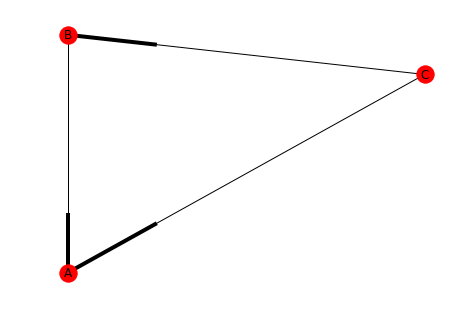

In [266]:
graph = nx.ego_graph(tm.graph, 'C', radius=100)
layout = nx.layout.spectral_layout(graph)
nx.draw(graph, pos=layout)
_ = nx.draw_networkx_labels(graph, layout)